## Edinburgh CCTV CNN Autoencoder (2D Latent Space)
 
Trains a convolutional autoencoder on the pixel data from the
trajectories CSV generated in the first notebook.

- Input: CSV with pixel columns (1x1, 1x2, ..., WxH or *_r/g/b)
- Output: trained CNN autoencoder with 2D latent space
- Config: all architecture and training hyperparameters are read from a YAML file


In [1]:
# # Optional: install dependencies in a fresh environment
# # Uncomment as needed.
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install pyyaml pandas numpy matplotlib scikit-learn umap-learn


In [2]:
import os
import re
import glob
import tarfile
import math
from typing import List, Optional, Tuple, Dict, Any

from PIL import Image
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from tqdm.auto import tqdm
import umap  # UMAP from umap-learn

# Filename pattern for Edinburgh frames (day_*.tar contents)
FILENAME_RE = re.compile(
    r"inspacecam163_(\d{4})_(\d{2})_(\d{2})_(\d{2})_(\d{2})_(\d{2})\.jpg$"
)

# Make matplotlib a bit nicer
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

print("PyTorch version:", torch.__version__)

PyTorch version: 2.5.1+cu121


## 1. Load YAML configuration


In [3]:
# Path to the YAML configuration file
# Adjust as needed
CONFIG_PATH = "configs/ae_cnn_umap.yaml"

if not os.path.exists(CONFIG_PATH):
    os.makedirs(os.path.dirname(CONFIG_PATH), exist_ok=True)
    example_cfg = """
seed: 0

data:
  # Folder containing day_*.tar files from the Edinburgh office dataset
  folder: "."
  grayscale: true              # true = convert to 1 channel, false = RGB (3 channels)
  use_all_times: false         # if true, ignore start_time/end_time
  start_time: "15:00:00"
  end_time: "15:59:59"
  frame_step: 10               # keep every N-th frame per day (after time filtering & sorting)
  max_samples: null            # null = use all selected frames, int = random subset
  train_fraction: 0.9          # fraction of samples used for training, rest for validation
  normalize: true              # divide pixel values by 255.0

  # Cache settings for decoded frames
  cache_root: "frame_cache"    # directory to put .npy frame cache files into
  use_cache: true              # if true, reuse cache if it exists

model:
  in_channels: 1               # 1 for grayscale, 3 for RGB
  img_width: 128
  img_height: 72
  conv_channels: [32, 64, 128] # encoder conv channels per stage
  kernel_size: 3
  latent_dim: 16               # latent feature dimension (will be reduced to 2D by UMAP)
  dropout: 0.1

training:
  num_epochs: 50
  batch_size: 256
  optimizer: adam              # "adam" or "sgd"
  learning_rate: 1.0e-3
  weight_decay: 1.0e-5

device:
  type: "auto"                 # "auto", "cuda", or "cpu"

logging:
  output_dir: "autoencoder_runs"
  run_name: "cnn_ae_v1"
  num_recon_examples: 8
  encode_batch_size: 1024      # batch size for encoding full dataset

umap:
  n_neighbors: 15
  min_dist: 0.1
  metric: "euclidean"
  n_components: 2
  random_state: 0
"""
    with open(CONFIG_PATH, "w", encoding="utf-8") as f:
        f.write(example_cfg.strip() + "\n")
    print(f"Wrote example config to {CONFIG_PATH}")

with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    config: Dict[str, Any] = yaml.safe_load(f)

print("Loaded config from:", CONFIG_PATH)
config

Loaded config from: configs/ae_cnn_umap.yaml


{'seed': 0,
 'data': {'folder': '.',
  'grayscale': True,
  'use_all_times': True,
  'start_time': '00:00:00',
  'end_time': '23:59:59',
  'frame_step': 1,
  'max_samples': None,
  'train_fraction': 0.95,
  'normalize': True,
  'cache_root': 'frame_cache',
  'use_cache': True},
 'model': {'in_channels': 1,
  'img_width': 128,
  'img_height': 72,
  'conv_channels': [32, 64, 128],
  'kernel_size': 3,
  'latent_dim': 16,
  'dropout': 0.1},
 'training': {'num_epochs': 10,
  'batch_size': 1024,
  'optimizer': 'adam',
  'learning_rate': 0.001,
  'weight_decay': 1e-05},
 'device': {'type': 'auto'},
 'logging': {'output_dir': 'autoencoder_runs',
  'run_name': 'cnn_ae_v1',
  'num_recon_examples': 8,
  'encode_batch_size': 1024},
 'umap': {'n_neighbors': 300,
  'min_dist': 0.1,
  'metric': 'euclidean',
  'n_components': 2,
  'random_state': 0,
  'max_points': 20000,
  'verbose': True}}

## 2. Reproducibility helpers and column detection


In [4]:
def set_global_seed(seed: int) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(False)


set_global_seed(config.get("seed", 0))

## 3. Index frames directly from day\_*.tar files

In [5]:
def parse_time_from_filename(name: str):
    """Returns (hour, minute, second) or None if the filename does not match."""
    base = os.path.basename(name)
    m = FILENAME_RE.match(base)
    if not m:
        return None
    h = int(m.group(4))
    m_ = int(m.group(5))
    s = int(m.group(6))
    return h, m_, s


def seconds_since_midnight(h: int, m: int, s: int) -> int:
    return h * 3600 + m * 60 + s


def parse_time_string(s: str) -> int:
    """
    Parse HH:MM or HH:MM:SS -> seconds since midnight.
    """
    parts = s.split(":")
    if len(parts) == 2:
        h, m = parts
        s_val = 0
    elif len(parts) == 3:
        h, m, s_val = parts
    else:
        raise ValueError(f"Invalid time format: {s!r}. Expected HH:MM or HH:MM:SS")
    h_i = int(h)
    m_i = int(m)
    s_i = int(s_val)
    if not (0 <= h_i < 24 and 0 <= m_i < 60 and 0 <= s_i < 60):
        raise ValueError(f"Time out of range: {s!r}")
    return seconds_since_midnight(h_i, m_i, s_i)


def time_filter(day_sec: int, start_sec: int, end_sec: int, use_all_times: bool) -> bool:
    if use_all_times:
        return True
    return start_sec <= day_sec <= end_sec


def list_tar_files(folder: str) -> List[str]:
    pattern = os.path.join(folder, "day_*.tar")
    tar_paths = sorted(glob.glob(pattern))
    if not tar_paths:
        raise SystemExit(f"No tar files matching 'day_*.tar' found in {folder}")
    return tar_paths


data_cfg = config["data"]
model_cfg = config["model"]

data_folder = data_cfg["folder"]
grayscale = bool(data_cfg.get("grayscale", True))
use_all_times = bool(data_cfg.get("use_all_times", True))
start_time = data_cfg.get("start_time", "00:00:00")
end_time = data_cfg.get("end_time", "23:59:59")
frame_step = int(data_cfg.get("frame_step", 1))
max_samples = data_cfg.get("max_samples", None)

img_w = int(model_cfg["img_width"])
img_h = int(model_cfg["img_height"])
in_channels_model = int(model_cfg["in_channels"])
in_channels_data = 1 if grayscale else 3
if in_channels_model != in_channels_data:
    raise SystemExit(
        f"model.in_channels={in_channels_model} does not match data.grayscale "
        f"(expected {in_channels_data} channels)."
    )
in_channels = in_channels_model

if frame_step <= 0:
    raise ValueError("data.frame_step must be >= 1")

if use_all_times:
    start_sec = 0
    end_sec = 24 * 3600 - 1
else:
    start_sec = parse_time_string(start_time)
    end_sec = parse_time_string(end_time)
    if end_sec < start_sec:
        raise ValueError("end_time must be >= start_time")

tar_paths = list_tar_files(data_folder)
print(f"Found {len(tar_paths)} tar files in {data_folder}")

frame_records: List[Dict[str, Any]] = []
line_index_by_path: Dict[str, int] = {}
line_counter = 0

for path in tqdm(tar_paths, desc="Scanning tar files"):
    line_id = line_counter
    line_index_by_path[path] = line_id
    line_counter += 1

    with tarfile.open(path, "r") as tar:
        members = [m for m in tar.getmembers() if m.isfile()]

        frames = []
        for member in tqdm(members, leave=False, desc=f"Reading {os.path.basename(path)}"):
            t = parse_time_from_filename(member.name)
            if t is None:
                continue
            h, m_, s = t
            day_sec = seconds_since_midnight(h, m_, s)
            if not time_filter(day_sec, start_sec, end_sec, use_all_times):
                continue
            time_str = f"{h:02d}:{m_:02d}:{s:02d}"
            frames.append((day_sec, time_str, member.name))

        # Sort in time and apply per-day frame_step
        frames.sort(key=lambda x: x[0])
        frames = frames[::frame_step]

        for step, (day_sec, time_str, member_name) in enumerate(frames):
            frame_records.append(
                {
                    "tar_path": path,
                    "member_name": member_name,
                    "line": line_id,
                    "step": step,
                    "day_sec": day_sec,
                    "time_str": time_str,
                }
            )

if not frame_records:
    raise SystemExit("No frames found in the specified time window.")

print(f"Total selected frames before sampling: {len(frame_records)}")

if max_samples is not None:
    max_samples = int(max_samples)
    if max_samples > 0 and max_samples < len(frame_records):
        rng = np.random.default_rng(config.get("seed", 0))
        idx = rng.choice(len(frame_records), size=max_samples, replace=False)
        idx_sorted = np.sort(idx)
        frame_records = [frame_records[i] for i in tqdm(idx_sorted, desc="Applying max_samples")]
        print(f"Subsampled to {len(frame_records)} frames based on max_samples={max_samples}")

line_col_present = True

print("Distinct trajectories (days):", len(line_index_by_path))
print("Final number of frames:", len(frame_records))
print("Image dimensions:", img_w, "x", img_h, "channels =", in_channels)

Found 12 tar files in .


Scanning tar files:   0%|          | 0/12 [00:00<?, ?it/s]

Reading day_1.tar:   0%|          | 0/10047 [00:00<?, ?it/s]

Reading day_10.tar:   0%|          | 0/16253 [00:00<?, ?it/s]

Reading day_11.tar:   0%|          | 0/29568 [00:00<?, ?it/s]

Reading day_12.tar:   0%|          | 0/22344 [00:00<?, ?it/s]

Reading day_2.tar:   0%|          | 0/6719 [00:00<?, ?it/s]

Reading day_3.tar:   0%|          | 0/27235 [00:00<?, ?it/s]

Reading day_4.tar:   0%|          | 0/13082 [00:00<?, ?it/s]

Reading day_5.tar:   0%|          | 0/21793 [00:00<?, ?it/s]

Reading day_6.tar:   0%|          | 0/12652 [00:00<?, ?it/s]

Reading day_7.tar:   0%|          | 0/31706 [00:00<?, ?it/s]

Reading day_8.tar:   0%|          | 0/29002 [00:00<?, ?it/s]

Reading day_9.tar:   0%|          | 0/16250 [00:00<?, ?it/s]

Total selected frames before sampling: 236651
Distinct trajectories (days): 12
Final number of frames: 236651
Image dimensions: 128 x 72 channels = 1


## 4.2 Build or load cached frame tensor

Decode all selected frames *once* into a tensor of shape (N, C, H, W).
If a cache file exists, load it instead of touching the tar files again.

In [6]:
from numpy.lib.format import open_memmap

cache_root = data_cfg.get("cache_root", "frame_cache")
os.makedirs(cache_root, exist_ok=True)

folder = data_cfg["folder"]
folder_name = os.path.basename(os.path.abspath(folder)) or "root"

use_all_times_cfg = bool(data_cfg.get("use_all_times", False))
if use_all_times_cfg:
    tw_str = "all"
else:
    start_time_cfg = data_cfg.get("start_time", "00:00:00")
    end_time_cfg = data_cfg.get("end_time", "23:59:59")
    tw_str = f"{start_time_cfg.replace(':','')}-{end_time_cfg.replace(':','')}"

mode = "gray" if data_cfg.get("grayscale", True) else "rgb"
frame_step_cfg = int(data_cfg.get("frame_step", 1))
seed_value = config.get("seed", 0)

base_data_id = (
    f"{folder_name}_w{img_w}h{img_h}_{mode}_tw{tw_str}_step{frame_step_cfg}_seed{seed_value}"
)
frames_path = os.path.join(cache_root, base_data_id + "_frames_uint8.npy")
lines_path = os.path.join(cache_root, base_data_id + "_lines_int64.npy")

# These will be used by the Dataset in the next cell
frames_np: np.memmap
lines_np: np.ndarray

if (
    os.path.exists(frames_path)
    and os.path.exists(lines_path)
    and data_cfg.get("use_cache", True)
):
    print(f"Loading memmapped frames from {frames_path}")
    frames_np = np.load(frames_path, mmap_mode="r")  # memmap (N, C, H, W), uint8
    lines_np = np.load(lines_path)                   # (N,), int64
    print("Loaded frame memmap:", frames_np.shape, frames_np.dtype)
else:
    print("No uint8 cache found; building from tar files into memmap...")

    N = len(frame_records)
    C = in_channels
    H = img_h
    W = img_w

    frames_mm = open_memmap(
        frames_path,
        mode="w+",
        dtype=np.uint8,
        shape=(N, C, H, W),
    )
    lines_arr = np.empty((N,), dtype=np.int64)

    tar_cache_local: Dict[str, tarfile.TarFile] = {}

    try:
        for i, rec in enumerate(tqdm(frame_records, desc="Decoding frames into memmap")):
            tar_path = rec["tar_path"]
            if tar_path not in tar_cache_local:
                tar_cache_local[tar_path] = tarfile.open(tar_path, "r")

            tf = tar_cache_local[tar_path]
            member = tf.getmember(rec["member_name"])
            fileobj = tf.extractfile(member)
            if fileobj is None:
                raise RuntimeError(
                    f"Could not extract {rec['member_name']} from {rec['tar_path']}"
                )

            img = Image.open(fileobj)
            if grayscale:
                img = img.convert("L")
            else:
                img = img.convert("RGB")

            img = img.resize((img_w, img_h), resample=Image.BILINEAR)
            arr = np.array(img, dtype=np.uint8)

            if grayscale:
                # (H, W) -> (1, H, W)
                arr_chw = arr[np.newaxis, :, :]
            else:
                # (H, W, C) -> (C, H, W)
                arr_chw = np.transpose(arr, (2, 0, 1))

            frames_mm[i] = arr_chw
            lines_arr[i] = rec["line"]

        frames_mm.flush()
    finally:
        for tf in tar_cache_local.values():
            tf.close()

    np.save(lines_path, lines_arr)
    print("Saved frame memmap to:", frames_path)
    print("Saved line ids to:", lines_path)

    frames_np = np.load(frames_path, mmap_mode="r")
    lines_np = np.load(lines_path)

print("Memmapped frames ready:", frames_np.shape, frames_np.dtype)
print("Lines array:", lines_np.shape, lines_np.dtype)

line_col_present = True

Loading memmapped frames from frame_cache\edinburgh-office-data_w128h72_gray_twall_step1_seed0_frames_uint8.npy
Loaded frame memmap: (236651, 1, 72, 128) uint8
Memmapped frames ready: (236651, 1, 72, 128) uint8
Lines array: (236651,) int64


## 4. Dataset and DataLoader (uint8 memmap)
Frames live in a uint8 memmap on disk. Each batch is converted to float32
and normalized to [0, 1] by the Dataset.

In [7]:
class MemmapFrameDataset(Dataset):
    def __init__(
        self,
        frames: np.memmap,
        lines: np.ndarray,
        normalize: bool = True,
        return_line: bool = True,
    ):
        """
        frames: memmap (N, C, H, W), dtype uint8
        lines:  ndarray (N,), dtype int64
        """
        self.frames = frames
        self.lines = lines if return_line else None
        self.normalize = normalize
        self.return_line = return_line

    def __len__(self) -> int:
        return self.frames.shape[0]

    def __getitem__(self, idx: int):
        frame_uint8 = self.frames[idx]
        img = torch.as_tensor(frame_uint8, dtype=torch.float32)
        if self.normalize:
            img = img / 255.0

        if self.lines is not None:
            line_val = int(self.lines[idx])
            return img, line_val
        return img


normalize_flag = bool(config["data"].get("normalize", True))

full_dataset = MemmapFrameDataset(
    frames=frames_np,
    lines=lines_np,
    normalize=normalize_flag,
    return_line=line_col_present,
)

print("Dataset length:", len(full_dataset))

# Train/validation split
train_fraction = float(config["data"].get("train_fraction", 0.9))
train_fraction = max(0.0, min(1.0, train_fraction))
n_total = len(full_dataset)
n_train = int(round(train_fraction * n_total))
n_val = n_total - n_train

if n_train == 0 or n_val == 0:
    train_dataset = full_dataset
    val_dataset: Optional[Dataset] = None
    print("No train/validation split performed.")
else:
    generator = torch.Generator().manual_seed(config.get("seed", 0))
    train_dataset, val_dataset = random_split(
        full_dataset,
        [n_train, n_val],
        generator=generator,
    )
    print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

train_cfg = config["training"]
batch_size = int(train_cfg["batch_size"])

num_workers = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
)

val_loader = None
if val_dataset is not None:
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

sample_batch = next(iter(train_loader))
if line_col_present:
    sample_imgs, sample_lines = sample_batch
else:
    sample_imgs = sample_batch
print("Sample batch image tensor shape:", sample_imgs.shape)

Dataset length: 236651
Train samples: 224818, Validation samples: 11833


C:\Users\Christian\AppData\Local\Temp\ipykernel_4892\2650193287.py:23: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:212.)
  img = torch.as_tensor(frame_uint8, dtype=torch.float32)


Sample batch image tensor shape: torch.Size([1024, 1, 72, 128])


## 5. CNN Autoencoder definition (2D latent space)


In [8]:
class ConvAutoencoder(nn.Module):
    """
    Convolutional autoencoder with a configurable stack of encoder conv blocks
    and mirrored decoder transposed-conv blocks. Latent space is a vector of size
    `latent_dim` (typically >2), which is later reduced to 2D by UMAP.
    """

    def __init__(
        self,
        in_channels: int,
        img_height: int,
        img_width: int,
        conv_channels: List[int],
        kernel_size: int = 3,
        latent_dim: int = 16,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.img_h = img_height
        self.img_w = img_width
        self.latent_dim = latent_dim

        padding = kernel_size // 2

        # Encoder
        encoder_layers: List[nn.Module] = []
        c_in = in_channels
        for c_out in conv_channels:
            encoder_layers.append(
                nn.Conv2d(
                    c_in,
                    c_out,
                    kernel_size=kernel_size,
                    stride=2,
                    padding=padding,
                    bias=False,
                )
            )
            encoder_layers.append(nn.BatchNorm2d(c_out))
            encoder_layers.append(nn.ReLU(inplace=True))
            if dropout > 0.0:
                encoder_layers.append(nn.Dropout2d(p=dropout))
            c_in = c_out
        self.encoder_conv = nn.Sequential(*encoder_layers)

        # Determine shape after encoder convs using a dummy pass
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, img_height, img_width)
            enc_out = self.encoder_conv(dummy)
        self.enc_out_shape = enc_out.shape[1:]  # (C, H, W)
        enc_flat_dim = int(enc_out.numel() // enc_out.shape[0])

        # Linear layers for latent code
        self.fc_enc = nn.Linear(enc_flat_dim, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, enc_flat_dim)

        # Decoder: mirror conv stacks with ConvTranspose2d
        decoder_layers: List[nn.Module] = []
        rev_channels = list(reversed(conv_channels))
        for i, c_in_dec in enumerate(rev_channels):
            if i + 1 < len(rev_channels):
                c_out_dec = rev_channels[i + 1]
                final = False
            else:
                c_out_dec = in_channels
                final = True

            decoder_layers.append(
                nn.ConvTranspose2d(
                    c_in_dec,
                    c_out_dec,
                    kernel_size=kernel_size,
                    stride=2,
                    padding=padding,
                    output_padding=1,
                    bias=False,
                )
            )

            if not final:
                decoder_layers.append(nn.BatchNorm2d(c_out_dec))
                decoder_layers.append(nn.ReLU(inplace=True))
            else:
                decoder_layers.append(nn.Sigmoid())

        self.decoder_conv = nn.Sequential(*decoder_layers)

        # Sanity check: confirm output shape matches input shape
        with torch.no_grad():
            x = torch.zeros(1, in_channels, img_height, img_width)
            recon = self.forward(x)[0]
        if recon.shape != x.shape:
            raise RuntimeError(
                f"Autoencoder output shape {recon.shape} does not match input shape {x.shape}. "
                f"Adjust conv configuration."
            )

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        h = self.encoder_conv(x)
        h = h.view(h.size(0), -1)
        z = self.fc_enc(h)
        return z

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        h = self.fc_dec(z)
        h = h.view(z.size(0), *self.enc_out_shape)
        x_recon = self.decoder_conv(h)
        return x_recon

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, z


conv_channels = [int(c) for c in model_cfg["conv_channels"]]
kernel_size = int(model_cfg.get("kernel_size", 3))
latent_dim = int(model_cfg.get("latent_dim", 16))
dropout = float(model_cfg.get("dropout", 0.0))

ae_model = ConvAutoencoder(
    in_channels=in_channels,
    img_height=img_h,
    img_width=img_w,
    conv_channels=conv_channels,
    kernel_size=kernel_size,
    latent_dim=latent_dim,
    dropout=dropout,
)

print(ae_model)

ConvAutoencoder(
  (encoder_conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout2d(p=0.1, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout2d(p=0.1, inplace=False)
  )
  (fc_enc): Linear(in_features=18432, out_features=16, bias=True)
  (fc_dec): Linear(in_features=16, out_features=18432, bias=True)
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3,

## 6. Training setup


In [9]:
device_cfg = config.get("device", {"type": "auto"})
device_type = device_cfg.get("type", "auto")

if device_type == "cuda":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
elif device_type == "cpu":
    device = torch.device("cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Training device:", device)

ae_model = ae_model.to(device)

train_cfg = config["training"]
num_epochs = int(train_cfg["num_epochs"])
learning_rate = float(train_cfg["learning_rate"])
weight_decay = float(train_cfg.get("weight_decay", 0.0))
optimizer_name = train_cfg.get("optimizer", "adam").lower()

criterion = nn.MSELoss()

if optimizer_name == "adam":
    optimizer = torch.optim.Adam(
        ae_model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,
    )
elif optimizer_name == "sgd":
    optimizer = torch.optim.SGD(
        ae_model.parameters(),
        lr=learning_rate,
        momentum=0.9,
        weight_decay=weight_decay,
    )
else:
    raise ValueError(f"Unsupported optimizer: {optimizer_name}")

print("Optimizer:", optimizer_name)
print("Learning rate:", learning_rate)
print("Weight decay:", weight_decay)


Training device: cuda
Optimizer: adam
Learning rate: 0.001
Weight decay: 1e-05


## 7. Training loop


In [10]:
def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
) -> float:
    model.train()
    running_loss = 0.0
    total_samples = 0

    pbar = tqdm(loader, desc="Train", leave=False)

    for batch in pbar:
        if line_col_present:
            imgs, _lines = batch
        else:
            imgs = batch

        imgs = imgs.to(device, non_blocking=True)

        optimizer.zero_grad()
        recon, _ = model(imgs)
        loss = criterion(recon, imgs)
        loss.backward()
        optimizer.step()

        batch_size = imgs.size(0)
        running_loss += loss.item() * batch_size
        total_samples += batch_size

        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    return running_loss / max(1, total_samples)


@torch.no_grad()
def eval_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device,
) -> float:
    model.eval()
    running_loss = 0.0
    total_samples = 0

    pbar = tqdm(loader, desc="Eval", leave=False)

    for batch in pbar:
        if line_col_present:
            imgs, _lines = batch
        else:
            imgs = batch

        imgs = imgs.to(device, non_blocking=True)
        recon, _ = model(imgs)
        loss = criterion(recon, imgs)

        batch_size = imgs.size(0)
        running_loss += loss.item() * batch_size
        total_samples += batch_size

        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    return running_loss / max(1, total_samples)


history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
}

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    train_loss = train_one_epoch(ae_model, train_loader, optimizer, device)

    if val_loader is not None:
        val_loss = eval_one_epoch(ae_model, val_loader, device)
    else:
        val_loss = float("nan")

    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    print(f"train_loss={train_loss:.6f}, val_loss={val_loss:.6f}")



Epoch 1/10


Train:   0%|          | 0/220 [00:00<?, ?it/s]

Eval:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss=0.008085, val_loss=0.004384

Epoch 2/10


Train:   0%|          | 0/220 [00:00<?, ?it/s]

Eval:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss=0.002546, val_loss=0.002345

Epoch 3/10


Train:   0%|          | 0/220 [00:00<?, ?it/s]

Eval:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss=0.001877, val_loss=0.001810

Epoch 4/10


Train:   0%|          | 0/220 [00:00<?, ?it/s]

Eval:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss=0.001490, val_loss=0.001490

Epoch 5/10


Train:   0%|          | 0/220 [00:00<?, ?it/s]

Eval:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss=0.001245, val_loss=0.001263

Epoch 6/10


Train:   0%|          | 0/220 [00:00<?, ?it/s]

Eval:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss=0.001131, val_loss=0.001119

Epoch 7/10


Train:   0%|          | 0/220 [00:00<?, ?it/s]

Eval:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss=0.001001, val_loss=0.001077

Epoch 8/10


Train:   0%|          | 0/220 [00:00<?, ?it/s]

Eval:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss=0.000947, val_loss=0.001044

Epoch 9/10


Train:   0%|          | 0/220 [00:00<?, ?it/s]

Eval:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss=0.000904, val_loss=0.000960

Epoch 10/10


Train:   0%|          | 0/220 [00:00<?, ?it/s]

Eval:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss=0.000862, val_loss=0.000842


## 8. Plot training curves


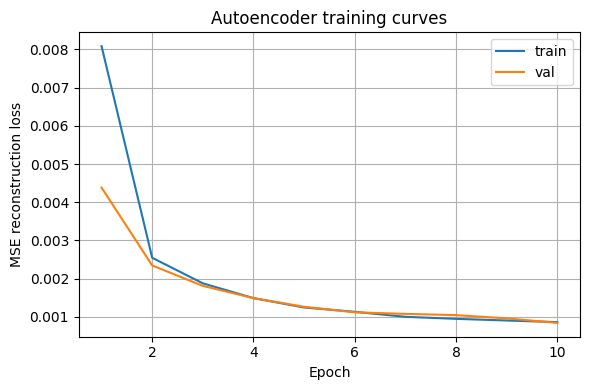

In [11]:
history_df = pd.DataFrame(history)
history_df.head()

plt.figure()
plt.plot(history_df["epoch"], history_df["train_loss"], label="train")
if not np.all(np.isnan(history_df["val_loss"].to_numpy())):
    plt.plot(history_df["epoch"], history_df["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE reconstruction loss")
plt.title("Autoencoder training curves")
plt.legend()
plt.tight_layout()
plt.show()

## 9. Save model, config snapshot, and training history

In [12]:
logging_cfg = config.get("logging", {})
output_dir = logging_cfg.get("output_dir", "autoencoder_runs")
os.makedirs(output_dir, exist_ok=True)

data_cfg = config["data"]
folder = data_cfg["folder"]
folder_name = os.path.basename(os.path.abspath(folder)) or "root"

use_all_times_save = bool(data_cfg.get("use_all_times", True))
if use_all_times_save:
    tw_str = "all"
else:
    start_time_save = data_cfg.get("start_time", "00:00:00")
    end_time_save = data_cfg.get("end_time", "23:59:59")
    tw_str = f"{start_time_save.replace(':','')}-{end_time_save.replace(':','')}"

mode = "gray" if data_cfg.get("grayscale", True) else "rgb"
frame_step_save = int(data_cfg.get("frame_step", 1))

base_data_id = f"{folder_name}_w{img_w}h{img_h}_{mode}_tw{tw_str}_step{frame_step_save}"

config_base = os.path.splitext(os.path.basename(CONFIG_PATH))[0]
seed_value = config.get("seed", 0)

run_id = f"{base_data_id}_{config_base}_seed{seed_value}"

model_base_name = f"ae_{run_id}"
model_path = os.path.join(output_dir, model_base_name + ".pt")
history_path = os.path.join(output_dir, model_base_name + "_history.csv")
config_snapshot_path = os.path.join(output_dir, model_base_name + "_config.yaml")

torch.save(
    {
        "model_state_dict": ae_model.state_dict(),
        "config": config,
        "history": history,
        "data_folder": folder,
        "frame_step": frame_step_save,
        "time_window": {
            "use_all_times": use_all_times_save,
            "start_time": data_cfg.get("start_time", "00:00:00"),
            "end_time": data_cfg.get("end_time", "23:59:59"),
        },
    },
    model_path,
)
print("Saved model to:", model_path)

history_df.to_csv(history_path, index=False)
print("Saved training history to:", history_path)

with open(config_snapshot_path, "w", encoding="utf-8") as f:
    yaml.safe_dump(config, f)
print("Saved config snapshot to:", config_snapshot_path)

Saved model to: autoencoder_runs\ae_edinburgh-office-data_w128h72_gray_twall_step1_ae_cnn_umap_seed0.pt
Saved training history to: autoencoder_runs\ae_edinburgh-office-data_w128h72_gray_twall_step1_ae_cnn_umap_seed0_history.csv
Saved config snapshot to: autoencoder_runs\ae_edinburgh-office-data_w128h72_gray_twall_step1_ae_cnn_umap_seed0_config.yaml


## 10. Reconstruction examples

Saved reconstruction grid to: autoencoder_runs\ae_edinburgh-office-data_w128h72_gray_twall_step1_ae_cnn_umap_seed0_recon.png


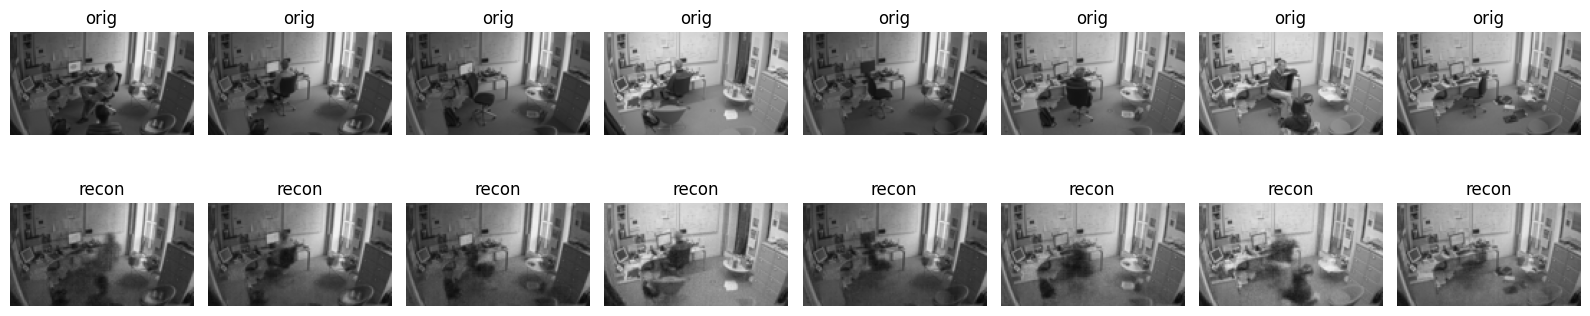

In [13]:
@torch.no_grad()
def plot_reconstructions(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device,
    num_examples: int = 8,
    out_path: Optional[str] = None,
):
    model.eval()
    batch = next(iter(loader))
    if line_col_present:
        imgs, _lines = batch
    else:
        imgs = batch

    imgs = imgs.to(device)
    recon, _ = model(imgs)

    imgs = imgs.cpu().numpy()
    recon = recon.cpu().numpy()

    n = min(num_examples, imgs.shape[0])

    fig, axes = plt.subplots(2, n, figsize=(n * 2, 4))
    for i in range(n):
        orig = imgs[i]
        rec = recon[i]

        if in_channels == 1:
            orig_img = orig[0]
            rec_img = rec[0]
            cmap = "gray"
        else:
            orig_img = np.transpose(orig, (1, 2, 0))
            rec_img = np.transpose(rec, (1, 2, 0))
            cmap = None

        axes[0, i].imshow(orig_img, cmap=cmap, vmin=0.0, vmax=1.0)
        axes[0, i].axis("off")
        axes[0, i].set_title("orig")

        axes[1, i].imshow(rec_img, cmap=cmap, vmin=0.0, vmax=1.0)
        axes[1, i].axis("off")
        axes[1, i].set_title("recon")

    plt.tight_layout()
    if out_path is not None:
        fig.savefig(out_path, dpi=300)
        print("Saved reconstruction grid to:", out_path)
    plt.show()


num_recon_examples = int(logging_cfg.get("num_recon_examples", 8))
recon_out_path = os.path.join(output_dir, model_base_name + "_recon.png")

loader_for_recon = val_loader if val_loader is not None else train_loader
plot_reconstructions(
    ae_model,
    loader_for_recon,
    device,
    num_examples=num_recon_examples,
    out_path=recon_out_path,
)

## Encode full dataset into latent space (N, latent_dim)

This replaces the old "2D latent scatter" using the raw bottleneck.
We now collect latent_dim-dimensional features for all frames.

In [14]:
@torch.no_grad()
def encode_dataset(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device,
    return_lines: bool = True,
) -> Tuple[np.ndarray, Optional[np.ndarray]]:
    """
    Encodes all samples from `loader` into latent vectors.

    Returns:
      - Z: (N, latent_dim) NumPy array
      - lines: (N,) NumPy array of line ids (if present), else None
    """
    model.eval()
    zs = []
    all_lines = [] if return_lines and line_col_present else None

    for batch in tqdm(loader, desc="Encoding dataset"):
        if line_col_present:
            imgs, batch_lines = batch
            if all_lines is not None:
                all_lines.append(batch_lines.numpy())
        else:
            imgs = batch

        imgs = imgs.to(device, non_blocking=True)
        z = model.encode(imgs)
        zs.append(z.cpu().numpy())

    Z = np.concatenate(zs, axis=0)
    if return_lines and line_col_present and all_lines is not None:
        lines = np.concatenate(all_lines, axis=0)
    else:
        lines = None

    return Z, lines


encode_batch_size = int(logging_cfg.get("encode_batch_size", 1024))

full_loader_for_encoding = DataLoader(
    full_dataset,
    batch_size=encode_batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

Z_latent, latent_lines = encode_dataset(
    ae_model, full_loader_for_encoding, device, return_lines=True
)
print("Full latent feature matrix shape:", Z_latent.shape)
if latent_lines is not None:
    print("Latent lines shape:", latent_lines.shape)

Encoding dataset:   0%|          | 0/232 [00:00<?, ?it/s]

Full latent feature matrix shape: (236651, 16)
Latent lines shape: (236651,)


## 12. UMAP on autoencoder latent features

Reduces latent_dim-dimensional features to 2D for visualization and export.
To avoid extremely slow runs on very large datasets, we optionally:
- fit UMAP on a random subset of points (size <= umap.max_points),
- then transform all latent vectors.
- This keeps complexity manageable while still using all points in the final embedding.


In [15]:
import logging
logging.basicConfig(level=logging.INFO)
logging.getLogger("umap").setLevel(logging.INFO)

umap.umap_.tqdm = True

import numba
numba.config.THREADING_LAYER = 'tbb'
numba.config.DUMP_ASSEMBLY = False
numba.config.LOGGING_LEVEL = 1

In [16]:
umap_cfg = config.get("umap", {})
umap_n_neighbors = int(umap_cfg.get("n_neighbors", 15))
umap_min_dist = float(umap_cfg.get("min_dist", 0.1))
umap_metric = umap_cfg.get("metric", "euclidean")
umap_n_components = int(umap_cfg.get("n_components", 2))
umap_random_state = umap_cfg.get("random_state", config.get("seed", 0))

# NEW: optional speed / verbosity settings
umap_max_points = umap_cfg.get("max_points", None)        # None → use all points
umap_verbose = bool(umap_cfg.get("verbose", True))

print("UMAP config:")
print("  n_neighbors:", umap_n_neighbors)
print("  min_dist:", umap_min_dist)
print("  metric:", umap_metric)
print("  n_components:", umap_n_components)
print("  random_state:", umap_random_state)
print("  max_points:", umap_max_points)
print("  verbose:", umap_verbose)

reducer = umap.UMAP(
    n_neighbors=umap_n_neighbors,
    min_dist=umap_min_dist,
    n_components=umap_n_components,
    metric=umap_metric,
    random_state=umap_random_state,
    verbose=umap_verbose,
)

N = Z_latent.shape[0]

# --- Corrected logic ---
use_subset = (
    umap_max_points is not None       # not None → user specified a value
    and isinstance(umap_max_points, int)
    and umap_max_points > 0
    and N > umap_max_points
)

if use_subset:
    rng = np.random.default_rng(umap_random_state)
    subset_idx = rng.choice(N, size=umap_max_points, replace=False)
    subset_idx = np.sort(subset_idx)

    print(f"UMAP: fitting on subset of {len(subset_idx)} points out of {N} total")
    Z_fit = Z_latent[subset_idx]
    embedding_subset = reducer.fit_transform(Z_fit)

    print("UMAP: transforming all points using fitted reducer")
    embedding_2d = reducer.transform(Z_latent)

else:
    # This includes umap_max_points=None
    print(f"UMAP: fitting on all {N} points")
    embedding_2d = reducer.fit_transform(Z_latent)

print("UMAP embedding shape:", embedding_2d.shape)


UMAP config:
  n_neighbors: 300
  min_dist: 0.1
  metric: euclidean
  n_components: 2
  random_state: 0
  max_points: 20000
  verbose: True
UMAP: fitting on subset of 20000 points out of 236651 total
UMAP(n_jobs=1, n_neighbors=300, random_state=0, verbose=True)
Mon Nov 17 15:17:37 2025 Construct fuzzy simplicial set
Mon Nov 17 15:17:37 2025 Finding Nearest Neighbors
Mon Nov 17 15:17:37 2025 Building RP forest with 12 trees


c:\Users\Christian\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Christian\miniconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Mon Nov 17 15:17:49 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Mon Nov 17 15:18:58 2025 Finished Nearest Neighbor Search
Mon Nov 17 15:19:02 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Nov 17 15:19:23 2025 Finished embedding
UMAP: transforming all points using fitted reducer


c:\Users\Christian\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Mon Nov 17 15:19:27 2025 Worst tree score: 0.99720000
Mon Nov 17 15:19:27 2025 Mean tree score: 0.99787917
Mon Nov 17 15:19:27 2025 Best tree score: 0.99855000
Mon Nov 17 15:19:29 2025 Forward diversification reduced edges from 6000000 to 106576
Mon Nov 17 15:19:34 2025 Reverse diversification reduced edges from 106576 to 106576
Mon Nov 17 15:19:37 2025 Degree pruning reduced edges from 120704 to 120704
Mon Nov 17 15:19:37 2025 Resorting data and graph based on tree order
Mon Nov 17 15:19:37 2025 Building and compiling search function


Epochs completed:   0%|            0/30 [00:00]

	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP embedding shape: (236651, 2)


## 13. Build UMAP embedding DataFrame (with metadata) and plot

We include:
- idx: index into the memmap / frame_records
- line: day/trajectory id (categorical, used for coloring)
- step, day_sec, daytime: from frame_records (if shapes match)
- umap_x, umap_y: 2D embedding coordinates

   idx     umap_x    umap_y  line  step  day_sec   daytime
0    0  12.873405  9.084140     0     0    57151  15:52:31
1    1  12.911227  9.174403     0     1    57152  15:52:32
2    2  12.911851  9.161077     0     2    57153  15:52:33
3    3  12.916354  9.166389     0     3    57154  15:52:34
4    4  12.909207  9.152463     0     4    57155  15:52:35
Saved UMAP scatterplot to: autoencoder_runs\ae_edinburgh-office-data_w128h72_gray_twall_step1_ae_cnn_umap_seed0_latent_umap.png


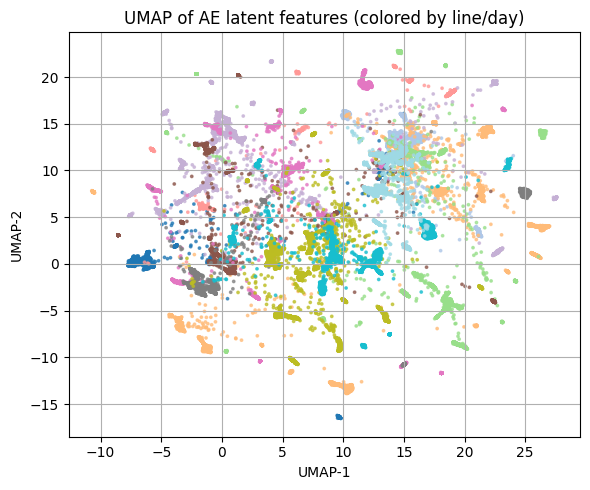

In [17]:
N = embedding_2d.shape[0]
idx = np.arange(N, dtype=np.int64)

# Sanity check: frame_records length should match number of frames
if len(frame_records) != N:
    print(
        "Warning: len(frame_records) != number of encoded samples; "
        "step/daytime metadata will be omitted."
    )
    steps = None
    day_secs = None
    daytimes = None
else:
    steps = np.array([rec["step"] for rec in frame_records], dtype=np.int64)
    day_secs = np.array([rec["day_sec"] for rec in frame_records], dtype=np.int64)
    daytimes = [rec["time_str"] for rec in frame_records]

df_umap = pd.DataFrame(
    {
        "idx": idx,
        "umap_x": embedding_2d[:, 0],
        "umap_y": embedding_2d[:, 1],
    }
)

if latent_lines is not None:
    df_umap["line"] = latent_lines

if steps is not None:
    df_umap["step"] = steps
if day_secs is not None:
    df_umap["day_sec"] = day_secs
if daytimes is not None:
    df_umap["daytime"] = daytimes

print(df_umap.head())


plt.figure(figsize=(6, 5))
if "line" in df_umap.columns:
    cat = pd.Categorical(df_umap["line"])
    codes = cat.codes
    sc = plt.scatter(
        df_umap["umap_x"],
        df_umap["umap_y"],
        c=codes,
        s=3,
        alpha=0.7,
        cmap="tab20",
    )
else:
    sc = plt.scatter(
        df_umap["umap_x"],
        df_umap["umap_y"],
        s=3,
        alpha=0.7,
    )

plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("UMAP of AE latent features (colored by line/day)")
plt.tight_layout()

umap_plot_path = os.path.join(output_dir, model_base_name + "_latent_umap.png")
plt.savefig(umap_plot_path, dpi=300)
print("Saved UMAP scatterplot to:", umap_plot_path)
plt.show()

## 14. Save UMAP embedding to CSV

The filename reflects that this is UMAP on AE latent space and is tied
to the same run_id as the model.

In [18]:
umap_csv_path = os.path.join(output_dir, model_base_name + "_latent_umap.csv")
df_umap.to_csv(umap_csv_path, index=False)
print("Saved UMAP embedding CSV to:", umap_csv_path)

Saved UMAP embedding CSV to: autoencoder_runs\ae_edinburgh-office-data_w128h72_gray_twall_step1_ae_cnn_umap_seed0_latent_umap.csv
